# CSC 215 - MiniProject 3
## Khoi Hoang

In [115]:
import os
import csv
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import sklearn.feature_extraction.text as sk_text
import scipy as sp
import math
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.pyplot import figure, show
from IPython.display import Markdown, display
from sklearn import metrics

%matplotlib inline

In [151]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)    

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()    
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
# Print markdown style
def printmd(string):
    display(Markdown(string))
    
# feature rank
def perturbation_rank(model, x, y, names, regression):
    errors = []

    for i in range(x.shape[1]):
        hold = np.array(x[:, i])
        np.random.shuffle(x[:, i])
        
        if regression:
            pred = model.predict(x)
            error = metrics.mean_squared_error(y, pred)
        else:
            pred = model.predict_proba(x)
            error = metrics.log_loss(y, pred)
            
        errors.append(error)
        x[:, i] = hold
        
    max_error = np.max(errors)
    importance = [e/max_error for e in errors]

    data = {'name':names,'error':errors,'importance':importance}
    result = pd.DataFrame(data, columns = ['name','error','importance'])
    result.sort_values(by=['importance'], ascending=[0], inplace=True)
    result.reset_index(inplace=True, drop=True)
    return result

In [3]:
df = pd.read_csv('network_intrusion_data.csv')
df.columns = [
 'duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'outcome'
]

In [4]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [5]:
df.shape

(494020, 42)

In [6]:
# df = df.loc[:, (df != 0).any(axis=0)] #drop columns with all 0
unique_val = df.apply(pd.Series.nunique)
cols_to_drop = unique_val[unique_val==1].index
df = df.drop(cols_to_drop, axis=1)

In [7]:
df.shape

(494020, 40)

In [8]:
np.unique(df['outcome'].values,return_counts=True)

(array(['back.', 'buffer_overflow.', 'ftp_write.', 'guess_passwd.',
        'imap.', 'ipsweep.', 'land.', 'loadmodule.', 'multihop.',
        'neptune.', 'nmap.', 'normal.', 'perl.', 'phf.', 'pod.',
        'portsweep.', 'rootkit.', 'satan.', 'smurf.', 'spy.', 'teardrop.',
        'warezclient.', 'warezmaster.'], dtype=object),
 array([  2203,     30,      8,     53,     12,   1247,     21,      9,
             7, 107201,    231,  97277,      3,      4,    264,   1040,
            10,   1589, 280790,      2,    979,   1020,     20],
       dtype=int64))

In [9]:
# binary encode the outcome, 0 is good/normal and 1 is an attack
df['outcome'] = df['outcome'].apply(lambda x: '0' if x == 'normal.' else '1')

In [10]:
np.unique(df['outcome'].values,return_counts=True)

(array(['0', '1'], dtype=object), array([ 97277, 396743], dtype=int64))

In [11]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0


In [12]:
df.drop_duplicates(keep='first', inplace=True)

In [13]:
df.shape

(145584, 40)

In [14]:
np.unique(df['outcome'].values,return_counts=True)
#df.dtypes

(array(['0', '1'], dtype=object), array([87831, 57753], dtype=int64))

In [15]:
#from sklearn.preprocessing import StandardScaler

scaler = preprocessing.StandardScaler()

cols_to_normalize = df.select_dtypes(include=['int64', 'float64']).columns
numeric_features = scaler.fit_transform(df.select_dtypes(include=['float64','int64']))

numeric_features = pd.DataFrame(numeric_features, columns=cols_to_normalize)

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [16]:
numeric_features.shape

(145584, 36)

In [17]:
scaler = preprocessing.LabelEncoder()

cols_to_encode = df.select_dtypes(include=['object']).columns
label_features = df.select_dtypes(include=['object']).apply(scaler.fit_transform)

label_features = pd.DataFrame(label_features, columns=cols_to_encode)

In [18]:
label_features.head()

,protocol_type,service,flag,outcome
0,1,22,9,0
1,1,22,9,0
2,1,22,9,0
3,1,22,9,0
4,1,22,9,0


In [19]:
label_features.drop(columns=['outcome'], inplace=True)

In [20]:
label_features.shape

(145584, 3)

In [21]:
numeric_features.reset_index(drop=True, inplace=True)
label_features.reset_index(drop=True, inplace=True)
input_data = pd.concat([numeric_features, label_features], axis=1)
input_data.shape

(145584, 39)

In [22]:
output_data = df['outcome']
output_data.shape

(145584,)

# Sklearn models

In [34]:
x_train, x_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.25, random_state=43)

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Initiate and train all the models
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

svc = LinearSVC(dual=False)
svc.fit(x_train, y_train)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)

gnb = GaussianNB()
gnb.fit(x_train, y_train)

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GaussianNB(priors=None, var_smoothing=1e-09)

-----------------**Logistic Regression Report**---------------

F1 score: 0.9879291734906172
Confusion matrix: 
 [[21785   157]
 [  282 14172]]
Plotting confusion matrix


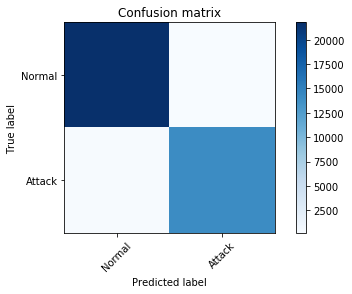

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     21942
           1       0.99      0.98      0.98     14454

   micro avg       0.99      0.99      0.99     36396
   macro avg       0.99      0.99      0.99     36396
weighted avg       0.99      0.99      0.99     36396



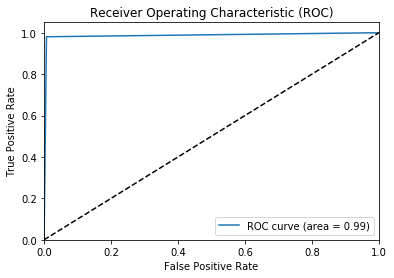

In [40]:
y_pred_Logistic = logreg.predict(x_test)
logistic_f1 = metrics.f1_score(y_test, y_pred_Logistic, average= "weighted")
logistic_cm = confusion_matrix(y_test, y_pred_Logistic)
printmd("-----------------**Logistic Regression Report**---------------")
print("F1 score: {}".format(logistic_f1))
print("Confusion matrix: \n", logistic_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(logistic_cm, ['Normal', 'Attack'])
plt.show()

print(classification_report(y_test, y_pred_Logistic))

plot_roc(y_pred_Logistic.astype(np.int), y_test.astype(np.int))

In [39]:
y_pred_Logistic.astype(np.int)

array([1, 0, 0, ..., 0, 1, 0])

-----------------**SVM Report**---------------

F1 score: 0.9845662371075575
Confusion matrix: 
 [[21768   174]
 [  387 14067]]
Plotting confusion matrix


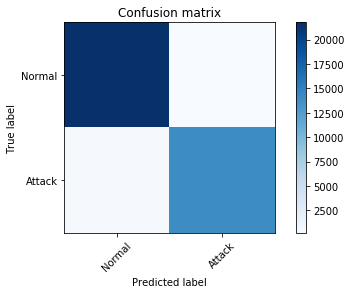

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     21942
           1       0.99      0.97      0.98     14454

   micro avg       0.98      0.98      0.98     36396
   macro avg       0.99      0.98      0.98     36396
weighted avg       0.98      0.98      0.98     36396



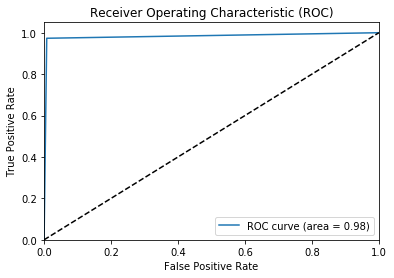

In [41]:
y_pred_svc = svc.predict(x_test)
svc_f1 = metrics.f1_score(y_test, y_pred_svc, average= "weighted")
svc_cm = confusion_matrix(y_test, y_pred_svc)
printmd("-----------------**SVM Report**---------------")
print("F1 score: {}".format(svc_f1))
print("Confusion matrix: \n", svc_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(svc_cm, ['Normal', 'Attack'])
plt.show()

print(classification_report(y_test, y_pred_svc))

plot_roc(y_pred_svc.astype(np.int), y_test.astype(np.int))

-----------------**KNN Report**---------------

F1 score: 0.9976089597579206
Confusion matrix: 
 [[21922    20]
 [   67 14387]]
Plotting confusion matrix


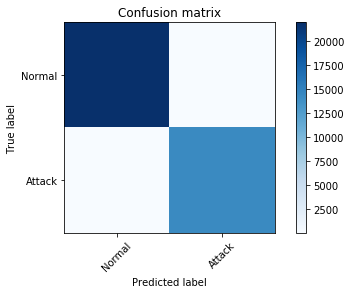

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21942
           1       1.00      1.00      1.00     14454

   micro avg       1.00      1.00      1.00     36396
   macro avg       1.00      1.00      1.00     36396
weighted avg       1.00      1.00      1.00     36396



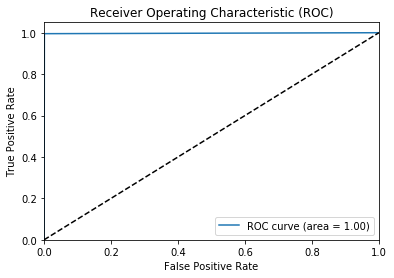

In [43]:
y_pred_knn = knn.predict(x_test)
knn_f1 = metrics.f1_score(y_test, y_pred_knn, average= "weighted")
knn_cm = confusion_matrix(y_test, y_pred_knn)
printmd("-----------------**KNN Report**---------------")
print("F1 score: {}".format(knn_f1))
print("Confusion matrix: \n", knn_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(knn_cm, ['Normal', 'Attack'])
plt.show()

print(classification_report(y_test, y_pred_knn))

plot_roc(y_pred_knn.astype(np.int), y_test.astype(np.int))

-----------------**Gaussian Naive Bayes Report**---------------

F1 score: 0.9745197538076749
Confusion matrix: 
 [[21685   257]
 [  668 13786]]
Plotting confusion matrix


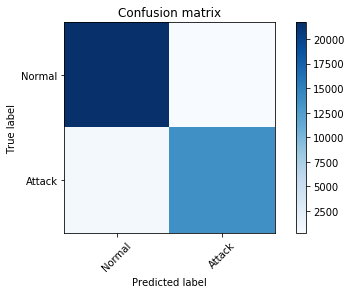

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     21942
           1       0.98      0.95      0.97     14454

   micro avg       0.97      0.97      0.97     36396
   macro avg       0.98      0.97      0.97     36396
weighted avg       0.97      0.97      0.97     36396



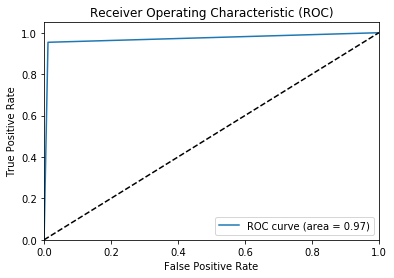

In [44]:
y_pred_gnb = gnb.predict(x_test)
gnb_f1 = metrics.f1_score(y_test, y_pred_gnb, average= "weighted")
gnb_cm = confusion_matrix(y_test, y_pred_gnb)
printmd("-----------------**Gaussian Naive Bayes Report**---------------")
print("F1 score: {}".format(gnb_f1))
print("Confusion matrix: \n", gnb_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(gnb_cm, ['Normal', 'Attack'])
plt.show()

print(classification_report(y_test, y_pred_gnb))

plot_roc(y_pred_gnb.astype(np.int), y_test.astype(np.int))

In [148]:
rank = perturbation_rank(svc, x_test, y_test, names, False)
rank
#x_test.shape

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [142]:
x_test[:,:]

TypeError: '(slice(None, None, None), slice(None, None, None))' is an invalid key

# Fully Connected Neural Network model

In [153]:
scaler = preprocessing.LabelEncoder()
output_tf = scaler.fit_transform(df['outcome'])
output_tf

array([0, 0, 0, ..., 0, 0, 0])

In [154]:
output_tf.shape

(145584,)

In [155]:
tf_data = input_data.copy()
tf_data['outcome'] = output_tf
tf_data.shape

(145584, 40)

In [156]:
x, y = to_xy(tf_data, 'outcome')

In [157]:
x_train_tf, x_test_tf, y_train_tf, y_test_tf = train_test_split(x, y, test_size=0.25, random_state=43)

In [158]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from tensorflow import keras

In [161]:
checkpointer = ModelCheckpoint(filepath=".\classification.hdf5", verbose=0, save_best_only=True) # save best model
activation_func = ['relu', 'tanh']
optimizer_func = ['adam', 'sgd']

for i in range(2):
    for j in range(2):
        printmd("**Activation** = {}  **Optimizer** = {} ".format(activation_func[i], optimizer_func[j]))
        #Build network
        model = Sequential()

        model.add(Dense(128, input_dim=x_train_tf.shape[1], activation=activation_func[i])) # Hidden 1     #  why input_dim=x.shape[1]?  
        model.add(Dropout(0.27))
        model.add(Dense(64, activation=activation_func[i])) # Hidden 2
        model.add(Dropout(0.27))
        model.add(Dense(32, activation=activation_func[i])) # Hidden 4
        model.add(Dense(y_train_tf.shape[1], activation='softmax')) # Output

        model.compile(loss='categorical_crossentropy', optimizer=optimizer_func[j], metrics=['accuracy'])

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

        model.fit(x_train_tf,y_train_tf, validation_data=(x_test_tf,y_test_tf), callbacks=[monitor,checkpointer],verbose=1,epochs=1000, batch_size=512, shuffle=True)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
    
print('Training finished...Loading the best model')  
print()
model.load_weights('.\classification.hdf5') # load weights from best model

**Activation** = relu  **Optimizer** = adam 

Train on 109188 samples, validate on 36396 samples
Epoch 1/1000
109188/109188 [==============================] - 3s 29us/step - loss: 0.1759 - acc: 0.9428 - val_loss: 0.0541 - val_acc: 0.9859
Epoch 2/1000
109188/109188 [==============================] - 1s 11us/step - loss: 0.0515 - acc: 0.9847 - val_loss: 0.0251 - val_acc: 0.9911
Epoch 3/1000
109188/109188 [==============================] - 1s 11us/step - loss: 0.0297 - acc: 0.9901 - val_loss: 0.0169 - val_acc: 0.9954
Epoch 4/1000
109188/109188 [==============================] - 1s 11us/step - loss: 0.0230 - acc: 0.9931 - val_loss: 0.0139 - val_acc: 0.9959
Epoch 5/1000
109188/109188 [==============================] - 1s 11us/step - loss: 0.0188 - acc: 0.9948 - val_loss: 0.0126 - val_acc: 0.9962
Epoch 6/1000
109188/109188 [==============================] - 1s 11us/step - loss: 0.0175 - acc: 0.9949 - val_loss: 0.0127 - val_acc: 0.9960
Epoch 7/1000
109188/109188 [==============================] - 1s 12us/step - loss: 0.0147 - acc: 0.9960

**Activation** = tanh  **Optimizer** = sgd 

Train on 109188 samples, validate on 36396 samples
Epoch 1/1000
109188/109188 [==============================] - 3s 27us/step - loss: 0.2365 - acc: 0.9188 - val_loss: 0.1074 - val_acc: 0.9716
Epoch 2/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.1187 - acc: 0.9692 - val_loss: 0.0912 - val_acc: 0.9760
Epoch 3/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.0971 - acc: 0.9740 - val_loss: 0.0815 - val_acc: 0.9794
Epoch 4/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.0879 - acc: 0.9761 - val_loss: 0.0774 - val_acc: 0.9802
Epoch 5/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.0816 - acc: 0.9780 - val_loss: 0.0698 - val_acc: 0.9823
Epoch 6/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.0767 - acc: 0.9792 - val_loss: 0.0698 - val_acc: 0.9823
Epoch 7/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.0735 - acc: 0.9801

In [162]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 128)               5120      
_________________________________________________________________
dropout_75 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_76 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_107 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_108 (Dense)            (None, 2)                 66        
Total params: 15,522
Trainable params: 15,522
Non-trainable params: 0
_________________________________________________________________


-----------------**Fully-Connected Neural Network Report**---------------

F1 score: 0.9585460941156094
Confusion matrix: 
 [[20465  1477]
 [   42 14412]]
Plotting confusion matrix


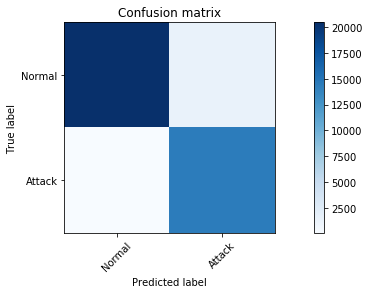

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     21942
           1       0.91      1.00      0.95     14454

   micro avg       0.96      0.96      0.96     36396
   macro avg       0.95      0.96      0.96     36396
weighted avg       0.96      0.96      0.96     36396



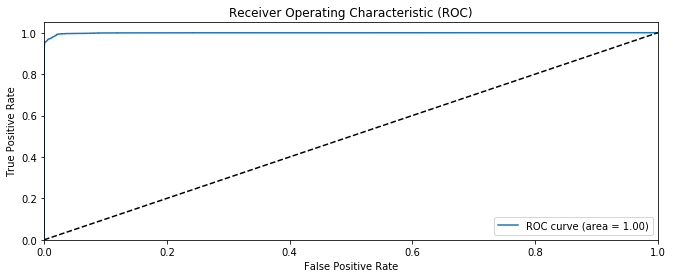

In [163]:
nn_pred = model.predict(x_test_tf)
nn_pred = np.argmax(nn_pred,axis=1)
y_true = np.argmax(y_test_tf,axis=1)

nn_f1 = metrics.f1_score(y_true, nn_pred, average= "weighted")
nn_cm = confusion_matrix(y_true, nn_pred)
printmd("-----------------**Fully-Connected Neural Network Report**---------------")
print("F1 score: {}".format(nn_f1))
print("Confusion matrix: \n", nn_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(nn_cm, ['Normal', 'Attack'])
plt.show()

print(classification_report(y_true, nn_pred))

nn_pred = model.predict(x_test_tf)
nn_pred = nn_pred[:,1] # Only positive class (1)
plot_roc(nn_pred,y_true)

In [164]:
names = list(df.columns) # x+y column names
names.remove("outcome") # remove the target(y)
rank = perturbation_rank(model, x_test_tf, y_test_tf, names, False)
rank

,name,error,importance
0,same_srv_rate,0.206381,1.000000
1,diff_srv_rate,0.204620,0.991463
2,num_shells,0.202002,0.978782
3,srv_serror_rate,0.182529,0.884424
4,dst_host_srv_diff_host_rate,0.168855,0.818171
5,dst_host_count,0.165370,0.801283
6,duration,0.163056,0.790071
7,land,0.156302,0.757344
8,dst_host_same_src_port_rate,0.155100,0.751523
9,src_bytes,0.148623,0.720137


# CNN model

In [62]:
x_train_tf, x_test_tf, y_train_tf, y_test_tf = train_test_split(x, y, test_size=0.25, random_state=43)

In [63]:
# reshape the input into 4D array
x_train_tf = x_train_tf.reshape(x_train_tf.shape[0], 1, x_train_tf.shape[1], 1)
x_test_tf = x_test_tf.reshape(x_test_tf.shape[0], 1, x_test_tf.shape[1], 1)

In [64]:
print(x_train_tf.shape)
print(x_test_tf.shape)

(109188, 1, 39, 1)
(36396, 1, 39, 1)


In [67]:
y_train_tf.shape, y_test_tf.shape

((109188, 2), (36396, 2))

In [104]:
y_test_tf.dtype

dtype('float32')

In [110]:
checkpointer = ModelCheckpoint(filepath=".\cnn.hdf5", verbose=0, save_best_only=True) # save best model
input_shape = (1, x_train_tf.shape[2], 1)
activation_func = ['relu', 'tanh']
optimizer_func = ['adam', 'sgd']

for i in range(2):
    for j in range(2):
        #Build network
        printmd("**Activation** = {}  **Optimizer** = {} ".format(activation_func[i], optimizer_func[j]))
        model = Sequential()

        model.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1), padding='valid',
                     activation=activation_func[i],
                     input_shape=input_shape))
        model.add(Conv2D(64, (1, 3), activation=activation_func[i]))
        model.add(MaxPooling2D(pool_size=(1, 2), strides=None))
        model.add(Dropout(0.25)) 
        model.add(Flatten())
        model.add(Dense(128, activation=activation_func[i]))
        model.add(Dropout(0.5))
        model.add(Dense(y_train_tf.shape[1], activation='softmax'))

        model.compile(loss="categorical_crossentropy", optimizer=optimizer_func[j], metrics=['accuracy'])

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

        model.fit(x_train_tf,y_train_tf, validation_data=(x_test_tf,y_test_tf), callbacks=[monitor,checkpointer],verbose=1,epochs=100, batch_size=512, shuffle=True)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
    
print('Training finished...Loading the best model')  
print()
model.load_weights('.\cnn.hdf5') # load weights from best model

**Activation** = relu  **Optimizer** = adam 

Train on 109188 samples, validate on 36396 samples
Epoch 1/100
109188/109188 [==============================] - 4s 32us/step - loss: 0.0719 - acc: 0.9760 - val_loss: 0.0264 - val_acc: 0.9937
Epoch 2/100
109188/109188 [==============================] - 2s 18us/step - loss: 0.0248 - acc: 0.9935 - val_loss: 0.0200 - val_acc: 0.9950
Epoch 3/100
109188/109188 [==============================] - 2s 18us/step - loss: 0.0223 - acc: 0.9942 - val_loss: 0.0179 - val_acc: 0.9960
Epoch 4/100
109188/109188 [==============================] - 2s 17us/step - loss: 0.0191 - acc: 0.9952 - val_loss: 0.0176 - val_acc: 0.9958
Epoch 5/100
109188/109188 [==============================] - 2s 18us/step - loss: 0.0160 - acc: 0.9959 - val_loss: 0.0146 - val_acc: 0.9962
Epoch 6/100
109188/109188 [==============================] - 2s 16us/step - loss: 0.0150 - acc: 0.9960 - val_loss: 0.0160 - val_acc: 0.9960
Epoch 7/100
109188/109188 [==============================] - 2s 17us/step - loss: 0.0142 - acc: 0.9963 - val_

**Activation** = relu  **Optimizer** = sgd 

Train on 109188 samples, validate on 36396 samples
Epoch 1/100
109188/109188 [==============================] - 3s 31us/step - loss: 0.3609 - acc: 0.8664 - val_loss: 0.1244 - val_acc: 0.9653
Epoch 2/100
109188/109188 [==============================] - 2s 16us/step - loss: 0.1353 - acc: 0.9614 - val_loss: 0.0892 - val_acc: 0.9753
Epoch 3/100
109188/109188 [==============================] - 2s 15us/step - loss: 0.1069 - acc: 0.9703 - val_loss: 0.0775 - val_acc: 0.9779
Epoch 4/100
109188/109188 [==============================] - 2s 16us/step - loss: 0.0933 - acc: 0.9749 - val_loss: 0.0715 - val_acc: 0.9790
Epoch 5/100
109188/109188 [==============================] - 2s 16us/step - loss: 0.0866 - acc: 0.9764 - val_loss: 0.0668 - val_acc: 0.9801
Epoch 6/100
109188/109188 [==============================] - 2s 15us/step - loss: 0.0804 - acc: 0.9777 - val_loss: 0.0637 - val_acc: 0.9804
Epoch 7/100
109188/109188 [==============================] - 2s 15us/step - loss: 0.0778 - acc: 0.9786 - val_

**Activation** = tanh  **Optimizer** = adam 

Train on 109188 samples, validate on 36396 samples
Epoch 1/100
109188/109188 [==============================] - 4s 33us/step - loss: 0.0544 - acc: 0.9818 - val_loss: 0.0209 - val_acc: 0.9927
Epoch 2/100
109188/109188 [==============================] - 2s 16us/step - loss: 0.0240 - acc: 0.9927 - val_loss: 0.0169 - val_acc: 0.9951
Epoch 3/100
109188/109188 [==============================] - 2s 16us/step - loss: 0.0198 - acc: 0.9938 - val_loss: 0.0179 - val_acc: 0.9934
Epoch 4/100
109188/109188 [==============================] - 2s 16us/step - loss: 0.0188 - acc: 0.9944 - val_loss: 0.0144 - val_acc: 0.9957
Epoch 5/100
109188/109188 [==============================] - 2s 16us/step - loss: 0.0170 - acc: 0.9946 - val_loss: 0.0142 - val_acc: 0.9959
Epoch 6/100
109188/109188 [==============================] - 2s 17us/step - loss: 0.0164 - acc: 0.9949 - val_loss: 0.0120 - val_acc: 0.9962
Epoch 7/100
109188/109188 [==============================] - 2s 18us/step - loss: 0.0140 - acc: 0.9959 - val_

**Activation** = tanh  **Optimizer** = sgd 

Train on 109188 samples, validate on 36396 samples
Epoch 1/100
109188/109188 [==============================] - 4s 33us/step - loss: 0.1577 - acc: 0.9563 - val_loss: 0.0978 - val_acc: 0.9739
Epoch 2/100
109188/109188 [==============================] - 2s 17us/step - loss: 0.0970 - acc: 0.9723 - val_loss: 0.0862 - val_acc: 0.9751
Epoch 3/100
109188/109188 [==============================] - 2s 16us/step - loss: 0.0876 - acc: 0.9743 - val_loss: 0.0795 - val_acc: 0.9760
Epoch 4/100
109188/109188 [==============================] - 2s 16us/step - loss: 0.0809 - acc: 0.9752 - val_loss: 0.0745 - val_acc: 0.9768
Epoch 5/100
109188/109188 [==============================] - 2s 16us/step - loss: 0.0763 - acc: 0.9766 - val_loss: 0.0701 - val_acc: 0.9776
Epoch 6/100
109188/109188 [==============================] - 2s 16us/step - loss: 0.0716 - acc: 0.9776 - val_loss: 0.0659 - val_acc: 0.9786
Epoch 7/100
109188/109188 [==============================] - 2s 17us/step - loss: 0.0680 - acc: 0.9785 - val_

In [111]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 1, 37, 32)         128       
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 1, 35, 64)         6208      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 1, 17, 64)         0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 1, 17, 64)         0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 1088)              0         
_________________________________________________________________
dense_83 (Dense)             (None, 128)               139392    
_________________________________________________________________
dropout_64 (Dropout)         (None, 128)               0         
__________

-----------------**Convolutional Neural Network Report**---------------

F1 score: 0.9773216786333887
Confusion matrix: 
 [[21937     5]
 [  816 13638]]
Plotting confusion matrix


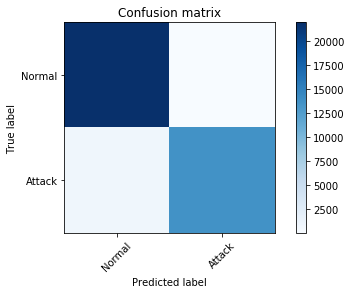

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21942
           1       1.00      0.94      0.97     14454

   micro avg       0.98      0.98      0.98     36396
   macro avg       0.98      0.97      0.98     36396
weighted avg       0.98      0.98      0.98     36396



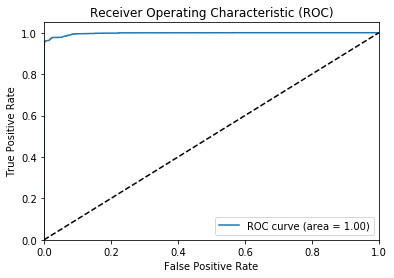

In [113]:
cnn_pred = model.predict(x_test_tf)
cnn_pred = np.argmax(cnn_pred,axis=1)
y_true = np.argmax(y_test_tf,axis=1)

cnn_f1 = metrics.f1_score(y_true, cnn_pred, average= "weighted")
cnn_cm = confusion_matrix(y_true, cnn_pred)
printmd("-----------------**Convolutional Neural Network Report**---------------")
print("F1 score: {}".format(cnn_f1))
print("Confusion matrix: \n", cnn_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cnn_cm, ['Normal', 'Attack'])
plt.show()

print(classification_report(y_true, cnn_pred))

cnn_pred = model.predict(x_test_tf)
cnn_pred = cnn_pred[:,1] # Only positive class (1)
plot_roc(cnn_pred,y_true)

In [131]:
def perturbation_rank_cnn(model, x, y, names, regression):
    errors = []

    for i in range(x.shape[2]):
        hold = np.array(x[:,:,i,:])
        np.random.shuffle(x[:,:,i,:])
        
        if regression:
            pred = model.predict(x)
            error = metrics.mean_squared_error(y, pred)
        else:
            pred = model.predict_proba(x)
            error = metrics.log_loss(y, pred)
            
        errors.append(error)
        x[:,:,i,:] = hold
        
    max_error = np.max(errors)
    importance = [e/max_error for e in errors]

    data = {'name':names,'error':errors,'importance':importance}
    result = pd.DataFrame(data, columns = ['name','error','importance'])
    result.sort_values(by=['importance'], ascending=[0], inplace=True)
    result.reset_index(inplace=True, drop=True)
    return result

In [132]:
names = list(df.columns)
names.remove('outcome')
rank = perturbation_rank_cnn(model, x_test_tf, y_test_tf, names, False)
rank
#print(x_test_tf.shape[2])

,name,error,importance
0,land,0.388850,1.000000
1,dst_host_srv_count,0.361948,0.930816
2,urgent,0.338932,0.871626
3,src_bytes,0.325124,0.836116
4,dst_host_srv_diff_host_rate,0.292677,0.752672
5,diff_srv_rate,0.279420,0.718581
6,srv_diff_host_rate,0.266334,0.684926
7,srv_rerror_rate,0.265522,0.682838
8,hot,0.264240,0.679543
9,dst_host_same_src_port_rate,0.262615,0.675363


In [149]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

rfc.fit(x_train, y_train)
importances = pd.DataFrame(rfc.feature_importances_, index = x_train.columns, columns=['importance']).sort_values('importance', ascending=False)

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [150]:
importances

,importance
same_srv_rate,0.171768
flag,0.152846
diff_srv_rate,0.118957
src_bytes,0.116678
logged_in,0.104555
serror_rate,0.064338
srv_serror_rate,0.062040
count,0.047982
dst_host_serror_rate,0.029720
dst_host_diff_srv_rate,0.016172
